In [2]:
import time
import numpy as np
import math as m
import sys
import datetime
%matplotlib inline
from matplotlib import pyplot as plt

import queue_model_fns as qu
from van_Doremalen_2020 import viral_half_lives
from Duguid_1946 import total_talk_small
import first_order_ODE as foode
from pulmonary_rate import pulmonary_rate

#seed random number generator
seed = int(time.time())
rD = np.random.default_rng(seed)
print('seed:',seed)

seed: 1635342228


## Set up

- Simulates usage of m-cubicle toilet block by a population with a background prevalence of an airborne infectious disease
- simulation period is 24hr, midnight to midnight
- arrivals are Markovian (with rate depending on time of day)
- general residence time distribution
- if someone arrives and all m cubicles are occupied, they join a queue

Calculates: 
- airborne pathogen concentration over the period
- pathogen exposure for each susceptible visitor + probability of infection
- expected total 2nd-ary infections over period

Where we are being naive:
- no account taken of fomite transmission
- we assume everyone uses toilet block for same purpose (so no washing, washing of clothes or other uses)
- we assume a very large population uses the block, with no one making repeat visits
- no mitigations

### Background disease prevalence rate - change this (value between 0 and 1)

In [3]:
prev = 0.1

### Buidling parameters - change these at will!

In [4]:
V = 1.5 * 5 * 2 #cubic metres

cubs = 4 #number of cubicles

people = 4
litrespersecondperperson = 0.25

In [5]:
Q = people * litrespersecondperperson * 60 * 60/ 1000 #total ventilation rate in m3/hour
Q_ACH = Q / V
print('Building volume: %.2f (m^3)' %V)
print('Ventilation rate: %.2f (m^3 per hour), %.2f (air changes per hour)' %(Q, Q_ACH))

Building volume: 15.00 (m^3)
Ventilation rate: 3.60 (m^3 per hour), 0.24 (air changes per hour)


### Decay rate of SARS-CoV-2 in aerosols [hour$^{-1}$] (van Doremalen 2020) - does not apply generally, so keep or change

In [6]:
gamma = {k_:m.log(2)/(v_) for k_, v_ in zip(viral_half_lives.keys(),
                                                 viral_half_lives.values())} #per hour [van Doremalen (2020)]

gamma_air = gamma['aerosol']
print('gamma_air: %.2f (per hour)' %gamma_air)

gamma_air: 0.63 (per hour)


### Quanta emission rate - change this

In [7]:
qer = 30.0 #per hour

### Residence time distribution

Naively gamma-distributed with mean approx. 6 mins.  However, we can make this more sophisticated by e.g. calibrating from Ghana data and taking into account different modes of usage, such as washing vs. toileting.

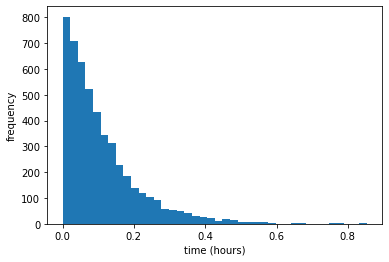

In [8]:
def residence_time(rD):
    #return 0.5
    return rD.gamma(shape=1.1, scale=1.0/10)

residence_times_hist = [residence_time(rD) for i in range(5000)]
plt.hist(residence_times_hist, bins=40)
plt.xlabel('time (hours)')
plt.ylabel('frequency')
plt.show()


### Arrival pattern - change this

Just made this up, but again, can play with this and/or use Ghana data

In [9]:
'''
very quiet: midnight to 6am
busy: 6am to 9am
quiet: 9am to 6pm
busy: 6pm to 10pm
quiet: 10pm to midnight
'''

very_quiet_rate = 0.6 #per hour
quiet_rate = 3.0 #per hour
busy_rate = 25.0 #per hour

## Run simulation

### 1. Simulate arrivals and usage

In [10]:
arrivals = []

qu.simulate_arrivals(very_quiet_rate, 0.0, 6.0, prev, arrivals, rD)
qu.simulate_arrivals(busy_rate, 6.0, 9.0, prev, arrivals, rD)
qu.simulate_arrivals(quiet_rate, 9.0, 18.0, prev, arrivals, rD)
qu.simulate_arrivals(busy_rate, 18.0, 22.0, prev, arrivals, rD)
qu.simulate_arrivals(quiet_rate, 22.0, 24.0, prev, arrivals, rD)

In [11]:
out_str = []
t, occ, inf, que, arrive_depart = qu.simulate_usage(cubs, arrivals, residence_time, out_str, rD)

In [12]:
#Uncomment below if you want to see simulated usage pattern listed
#for str in out_str:
#        print(str)
        

### 2. Calculate airborne concentration [quanta m$^{-3}$] at each change in occupancy

In [13]:
a =  qer / V
b = (Q/V + gamma_air)
C = qu.calculate_concentrations( t, inf, a, b, 0.0 )

### 3. Calculate each person's exposure [quanta]

#### notes

Gammaitoni and Nucci's model [Beggs, et al. 2003] in terms of airborne *concentration* rather than absolute airborne pathogen load is

\begin{align}
\frac{dS}{dt} &= - p\,C\,S\\
\frac{dC}{dt} &= \frac{q}{V} - (\frac{Q}{V} + \gamma_{\text{air}})\,C\\
\end{align}

where

$S = $ number of susceptibles

$C = $ airborne concentration [quanta per m${^3}$] 

$p = $ pulmonary ventilation rate [m${^3}$ per hour]

$Q = $ ventilation rate [m${^3}$ per hour]

$V = $ room volume [m${^3}$]

$\gamma_{\text{air}} = $ pathogen decay rate in aerosols [per hour]

$q = $ emission rate [quanta per hour].


Adapting to discrete infections, note that hazard of infection, per susceptible, is

\begin{equation}
h(t) = p\,C(t)
\end{equation}

and, therefore, probability of infection due to exposure to concentration $C(t)$ between $t_0$ and $t_1$ is

\begin{align}
    P_{\text{inf}} &= 1 - \exp\left\{-\int_{t_0}^{t_1} h(t)\,dt\right\}\\
    & = 1 - \exp\left\{-p\int_{t_0}^{t_1} C(t)\,dt\right\}.\\
\end{align}

E.g. total exposure to 1 quantum leads to infection with probability $1 - e^{-1} = 0.632$.

Integral is performed by function `calculate_exposures` in `queue_model_fns`

In [14]:
pulmonary_rates = pulmonary_rate( len(arrive_depart), rD) / 1000.0
E = np.array( qu.calculate_exposures( pulmonary_rates, arrive_depart, t, C, inf, a, b ) )

## View outputs

### 1. Occupancy & airborne concentration

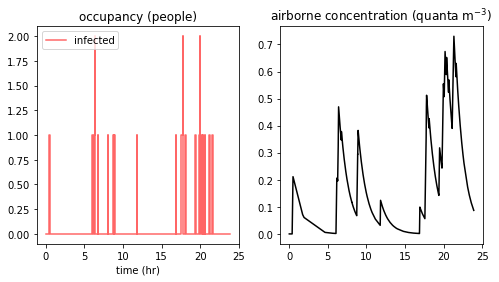

In [15]:
fig, ax = plt.subplots(1,2,sharex=True)

fig.set_size_inches( (8,4) )

#ax[0].step(t, occ, 'g-', where='post', label='occupants', alpha=0.6)
ax[0].step(t, inf, 'r-', where='post', label='infected', alpha=0.6)
#ax[0].step(t, que, 'b-', where='post', label='queue', alpha=0.6)
ax[0].legend( loc='upper left' )

ax[1].plot(t, C, 'k-')

ax[0].set_xlabel('time (hr)')
ax[0].set_title('occupancy (people)')
ax[1].set_title(r'airborne concentration (quanta m$^{-3}$)')
fig.savefig('toilet_block_occ')
plt.show()

### 2. Exposure

In [15]:
pinf = 1 - np.exp(-E)

print('time entered\ttime left\ttime spent\texposure (quanta)\tP(inf)')
print('--------------------------------------------------------------------------------------')
print('(susceptibles only)\n')
susceptibles = 0
for (a, d, _), e, pinf_ in zip(arrive_depart, E, pinf):
    if _ == 1:
        continue
    t_enter = str(datetime.timedelta(hours=a)).rsplit('.')[0]
    t_leave = str(datetime.timedelta(hours=d)).rsplit('.')[0]
    t_spent = str(datetime.timedelta(hours=d) - datetime.timedelta(hours=a)).rsplit('.')[0]
    susceptibles += 1
    #spent = (d-a)*60.0
    print(t_enter + '\t\t' + t_leave + '\t\t' + t_spent +'\t\t%.8f\t\t%.4f' %(e, pinf_))

time entered	time left	time spent	exposure (quanta)	P(inf)
--------------------------------------------------------------------------------------
(susceptibles only)

1:43:00		1:47:44		0:04:43		0.00000000		0.0000
3:31:24		3:39:54		0:08:30		0.00001956		0.0000
4:49:04		4:52:03		0:02:59		0.00000273		0.0000
6:00:27		6:11:08		0:10:40		0.00000251		0.0000
6:07:26		6:19:31		0:12:05		0.00008271		0.0001
6:07:51		6:18:29		0:10:37		0.00006173		0.0001
6:08:06		6:14:49		0:06:42		0.00000146		0.0000
6:11:16		6:14:13		0:02:57		0.00000115		0.0000
6:14:13		6:20:57		0:06:44		0.00007587		0.0001
6:14:49		6:15:08		0:00:19		0.00000097		0.0000
6:17:09		6:33:37		0:16:27		0.00021629		0.0002
6:19:13		6:38:34		0:19:21		0.00051088		0.0005
6:22:02		6:23:34		0:01:31		0.00001903		0.0000
6:23:23		6:24:33		0:01:09		0.00001559		0.0000
6:27:36		6:59:01		0:31:24		0.00112075		0.0011
6:33:37		6:39:24		0:05:46		0.00041808		0.0004
6:38:34		6:49:23		0:10:49		0.00052269		0.0005
6:39:24		6:42:43		0:03:18		0.00025007		0.0003
6:40:

### Expected number of secondary infections

In [16]:
E_infs = np.sum(pinf)
print('Expected 2nd-ary infections: %.3f out of %d susceptibles' %(E_infs, susceptibles) )

Expected 2nd-ary infections: 0.154 out of 183 susceptibles
